# DrawPSF, version 4 for paper


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS

- creation date : May 26th 2020
- update : June 1st 2020 : compute fwhm
- last update : April 6th 2021 : for the paper



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle,Ellipse

import matplotlib.colors as colors
import matplotlib.cm as cmx

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (13, 13),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size': 14}
plt.rcParams.update(params)

In [3]:
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

In [4]:
from datetime import datetime,date

In [5]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [6]:
import matplotlib.offsetbox
from matplotlib.lines import Line2D

##### scale bar
https://stackoverflow.com/questions/43258638/is-there-a-convenient-way-to-add-a-scale-indicator-to-a-plot-in-matplotlib

In [7]:
class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, linekw={},textkw={} ,**kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **linekw)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **linekw)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **linekw)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False,textprops=textkw)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon,
                 **kwargs)

In [8]:
def Dispersion(wl,a,D):
    """ 
    Dispersion(wl,a,D) : number of dx per wavelength
    input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx, x in microns and lambdas in microns
    """
    X=D/a*wl/np.sqrt(1-(wl/a)**2)
    return X

## Constants for conversions

In [9]:
m_to_mm=1000.
mm_to_m=1e-3
mm_to_micr=1e3
nm_to_micr=1e-3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm

In [10]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [11]:
deg_to_rad=np.pi/180.

In [12]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

## Configuration parameters at the telescope

#### telescope

In [13]:
Tel_Focal_Length=12.6 # m : Focal length of the telescope
Tel_Diameter=0.9 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter
pltscale=206265/(Tel_Focal_Length*m_to_mm)  # arcsec per mm

In [14]:
print("plate_scale={:2.2f} arcsec per mm ".format(pltscale))

plate_scale=16.37 arcsec per mm 


In [15]:
print("1 arsec = {:2.2f} microns".format(1/pltscale*mm_to_micr))

1 arsec = 61.09 microns


In [16]:
1/pltscale*mm_to_micr/2.36*3

77.65228784593788

#### filter

In [17]:
#Filt_D=0.05769 # m distance of the filter position wrt CCD plane
Filt_D=0.058 # m distance of the filter position wrt CCD plane
Filt_size=3*inch_to_mm

#### CCD detector

In [18]:
Det_xpic=24.0 # microns per pixel
#Det_NbPix=2048 # number of pixels per CCD side
Det_NbPix=2512 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

## Input file

In [19]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y
NWL=4
NBTOT=NBEAM*NWL

In [20]:
theta_x=0.  # angle in arcmin
theta_y=0.  # angle in arcmin 

In [21]:
theta_x_num=int(theta_x*10)
theta_y_num=int(theta_y*10)

In [22]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [23]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [24]:
Beam4_Rayfile="Beam4_Rayfile_{:d}_allwl_{}_{}".format(NBTOT,theta_x_str,theta_y_str)

In [25]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [26]:
order="OP1"
order_str="+1"

# Read input files

In [27]:
FLAG_R350=True # show RON350 instead of R200

In [28]:
#rayfile_hoe=Beam4_Rayfile+"_RAY_HOE_OUT.xlsx"
#rayfile_R400=Beam4_Rayfile+"_RAY_RON400_OUT.xlsx"
#rayfile_R200=Beam4_Rayfile+"_RAY_RON200_OUT.xlsx"
#rayfile_R350=Beam4_Rayfile+"_RAY_RON350_OUT.xlsx"

In [29]:
rayfile_R200="R200_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
rayfile_R350="R350_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
rayfile_R400="R400_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
rayfile_hoe="HOE_Beam4_Rayfile_484_allwl_m00_m00_2020_05_25_B4OUT_RAY.xlsx"
rayfile_R300="R300_Beam4_Rayfile_484_allwl_m00_m00_2020_05_31_B4OUT_RAY.xlsx"

In [30]:
input_hoe = pd.ExcelFile(rayfile_hoe)
df_hoe = input_hoe.parse(index_row=0,header=1)
df_hoe=df_hoe.iloc[0:NBTOT]

In [31]:
# rename columns otherwise they are not recognize and swap X,Y
#df_hoe.columns = ["X0","Y0","Z0","U0","V0","W0","wave","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xfinal","Yfinal","Zfinal","Notes"]
#df_hoe.columns = ["Y0","X0","Z0","V0","U0","W0","wave","Y1","X1","Z1","Y2","X2","Z2","Y3","X3","Z3","Yfinal","Xfinal","Zfinal","Notes"]

In [32]:
df_hoe

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,8.27790,-0.01283,79.99998,0,0,8.27790,-0.01283,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,8.28523,-0.01285,79.99998,0,0,8.28523,-0.01285,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,8.29260,-0.01287,79.99998,0,0,8.29260,-0.01287,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842679,-2.10670,...,8.30001,-0.01289,79.99998,0,0,8.30001,-0.01289,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,8.30745,-0.01291,79.99998,0,0,8.30745,-0.01291,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,21.97558,-0.05372,79.99998,0,0,21.97558,-0.05372,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842679,2.10670,...,21.94330,-0.05361,79.99998,0,0,21.94330,-0.05361,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,21.91098,-0.05350,79.99998,0,0,21.91098,-0.05350,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,21.87866,-0.05338,79.99998,0,0,21.87866,-0.05338,80,OK,3


In [33]:
input_R400 = pd.ExcelFile(rayfile_R400)
df_R400 = input_R400.parse(index_row=0,header=1)
df_R400=df_R400.iloc[0:NBTOT]

In [34]:
# rename columns otherwise they are not recognize
#df_R400.columns = ["X0","Y0","Z0","U0","V0","W0","wave","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xfinal","Yfinal","Zfinal","Notes"]

In [35]:
df_R400

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,9.50870,0.03953,80,0,0,9.50870,0.03953,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,9.48531,0.03701,80,0,0,9.48531,0.03701,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,9.46349,0.03451,80,0,0,9.46349,0.03451,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842678,-2.10670,...,9.44321,0.03201,80,0,0,9.44321,0.03201,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,9.42447,0.02953,80,0,0,9.42447,0.02953,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,25.21121,-0.18127,80,0,0,25.21121,-0.18127,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842678,2.10670,...,25.09532,-0.17373,80,0,0,25.09532,-0.17373,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,24.98470,-0.16628,80,0,0,24.98470,-0.16628,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,24.87929,-0.15892,80,0,0,24.87929,-0.15892,80,OK,3


In [36]:
input_R300 = pd.ExcelFile(rayfile_R300)
df_R300 = input_R300.parse(index_row=0,header=1)
df_R300=df_R300.iloc[0:NBTOT]

In [37]:
df_R300

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,7.07474,0.02426,80,0,0,7.07474,0.02426,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,7.06058,0.02241,80,0,0,7.06058,0.02241,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,7.04756,0.02057,80,0,0,7.04756,0.02057,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842678,-2.10670,...,7.03565,0.01874,80,0,0,7.03565,0.01874,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,7.02487,0.01691,80,0,0,7.02487,0.01691,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,18.19158,-0.09504,80,0,0,18.19158,-0.09504,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842678,2.10670,...,18.13355,-0.08999,80,0,0,18.13355,-0.08999,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,18.07880,-0.08500,80,0,0,18.07880,-0.08500,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,18.02729,-0.08003,80,0,0,18.02729,-0.08003,80,OK,3


In [38]:
input_R200 = pd.ExcelFile(rayfile_R200)
df_R200 = input_R200.parse(index_row=0,header=1)
df_R200=df_R200.iloc[0:NBTOT]

In [39]:
# rename columns otherwise they are not recognize
#df_R200.columns = ["X0","Y0","Z0","U0","V0","W0","wave","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xfinal","Yfinal","Zfinal","Notes"]

In [40]:
df_R200

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,4.68705,0.01269,80,0,0,4.68705,0.01269,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,4.67976,0.01147,80,0,0,4.67976,0.01147,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,4.67321,0.01027,80,0,0,4.67321,0.01027,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842678,-2.10670,...,4.66738,0.00906,80,0,0,4.66738,0.00906,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,4.66228,0.00786,80,0,0,4.66228,0.00786,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,11.82185,-0.03962,80,0,0,11.82185,-0.03962,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842678,2.10670,...,11.79859,-0.03650,80,0,0,11.79859,-0.03650,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,11.77726,-0.03340,80,0,0,11.77726,-0.03340,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,11.75785,-0.03031,80,0,0,11.75785,-0.03031,80,OK,3


In [41]:
input_R350 = pd.ExcelFile(rayfile_R350)
df_R350 = input_R350.parse(index_row=0,header=1)
df_R350=df_R350.iloc[0:NBTOT]

In [42]:
df_R350

,X0,Y0,Z0,U0,V0,W0,wave,col,X1,Y1,...,X3,Y3,Z3,Xgoal,Ygoal,Xfinal,Yfinal,Zfinal,Notes,Unnamed: 23
0,-2.856536,-2.856536,0,0.035661,0.035661,0.998727,0.0004,b,-2.106694,-2.10669,...,8.28509,0.03142,80,0,0,8.28509,0.03142,80,OK,3
1,-2.285228,-2.856536,0,0.028535,0.035669,0.998956,0.0004,b,-1.685357,-2.10670,...,8.26662,0.02923,80,0,0,8.26662,0.02923,80,OK,3
2,-1.713921,-2.856536,0,0.021406,0.035676,0.999134,0.0004,b,-1.264016,-2.10669,...,8.24951,0.02707,80,0,0,8.24951,0.02707,80,OK,3
3,-1.142614,-2.856536,0,0.014272,0.035680,0.999261,0.0004,b,-0.842678,-2.10670,...,8.23371,0.02491,80,0,0,8.23371,0.02491,80,OK,3
4,-0.571307,-2.856536,0,0.007137,0.035683,0.999338,0.0004,b,-0.421339,-2.10670,...,8.21925,0.02276,80,0,0,8.21925,0.02276,80,OK,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0.571307,2.856536,0,-0.007137,-0.035683,0.999338,0.0010,k,0.421339,2.10670,...,21.59873,-0.13376,80,0,0,21.59873,-0.13376,80,OK,3
480,1.142614,2.856536,0,-0.014272,-0.035680,0.999261,0.0010,k,0.842678,2.10670,...,21.51529,-0.12756,80,0,0,21.51529,-0.12756,80,OK,3
481,1.713921,2.856536,0,-0.021406,-0.035676,0.999134,0.0010,k,1.264016,2.10669,...,21.43600,-0.12143,80,0,0,21.43600,-0.12143,80,OK,3
482,2.285228,2.856536,0,-0.028535,-0.035669,0.998956,0.0010,k,1.685357,2.10670,...,21.36083,-0.11535,80,0,0,21.36083,-0.11535,80,OK,3


# Simulated FWHM with resampled beam

In [43]:
FWHMX_HOE_SIMBEAM = np.array([63,15,89,271])*micr_to_mm
FWHMY_HOE_SIMBEAM = np.array([22,6,30,90])*micr_to_mm

FWHMX_R400_SIMBEAM = np.array([124,325,585,1043])*micr_to_mm
FWHMY_R400_SIMBEAM = np.array([41,99,184,316])*micr_to_mm

FWHMX_R300_SIMBEAM = np.array([64,164,301,505])*micr_to_mm
FWHMY_R300_SIMBEAM = np.array([20,53,102,165])*micr_to_mm

# Choose disperser

In [133]:
FLAG_R400 = False
FLAG_R300 = False
FLAG_R350 = False
FLAG_R200 = False
FLAG_HOE = True

In [45]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [134]:
if FLAG_R400:
    df=df_R400
    outputdata_excel="R400_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
    figname1="R400_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="R400_PSF_" +   Beam4_Rayfile+".pdf"  
    figname3="R400_PSF_" +   Beam4_Rayfile+"_v2.pdf"  
    fulltitle1="Ronchi 400 : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle2="Ronchi 400 : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    Neff=400
    aeff=1/Neff
elif FLAG_R300:
    df=df_R300
    outputdata_excel="R300_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
    figname1="R300_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="R300_PSF_" +   Beam4_Rayfile+".pdf"  
    figname3="R300_PSF_" +   Beam4_Rayfile+"_v2.pdf"  
    fulltitle1="Ronchi 300 : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle2="Ronchi 300 : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    Neff=300
    aeff=1/Neff
elif FLAG_R350:
    df=df_R350
    outputdata_excel="R350_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
    figname1="R350_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="R350_PSF_" +   Beam4_Rayfile+".pdf"
    figname3="R350_PSF_" +   Beam4_Rayfile+"_v2.pdf"
    fulltitle1="Ronchi 350 : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle2="Ronchi 350 : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    Neff=350
    aeff=1/Neff
elif FLAG_R200:
    df=df_R200
    outputdata_excel="R200_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
    figname1="R200_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="R200_PSF_" +   Beam4_Rayfile+".pdf"
    figname3="R200_PSF_" +   Beam4_Rayfile+"_v2.pdf"
    fulltitle1="Ronchi 200 : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle2="Ronchi 200 : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    Neff=200
    aeff=1/Neff
else:
    df=df_hoe
    outputdata_excel="HOE_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
    figname1="HOE_DISP_"+  Beam4_Rayfile+".pdf"
    figname2="HOE_PSF_" +   Beam4_Rayfile+".pdf" 
    figname3="HOE_PSF_" +   Beam4_Rayfile+"_v2.pdf"
    fulltitle1="HOE : Dispersion at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    fulltitle2="HOE : PSF at Focal Plane for angles ({:2.2f} , {:2.2f}) arcmin, order = {}".format(theta_x,theta_y,order_str)
    #Neff=355
    Neff=354.7
    aeff=1/Neff

# Show beam

In [135]:
X0C=df["X0"].mean()
Y0C=df["Y0"].mean()

In [136]:
RXMAX=np.max(np.abs(df["X0"].values-X0C))
RYMAX=np.max(np.abs(df["Y0"].values-Y0C))          

In [137]:
RMAX=np.max(np.array([RXMAX,RYMAX]))

In [138]:
RMAX

2.8565355

In [139]:
def Select_Beam(row):
    return (row["X0"]-X0C)**2+(row["Y0"]-Y0C)**2 <= RMAX**2

Text(0.5, 0.98, 'Unfiltered square beam')

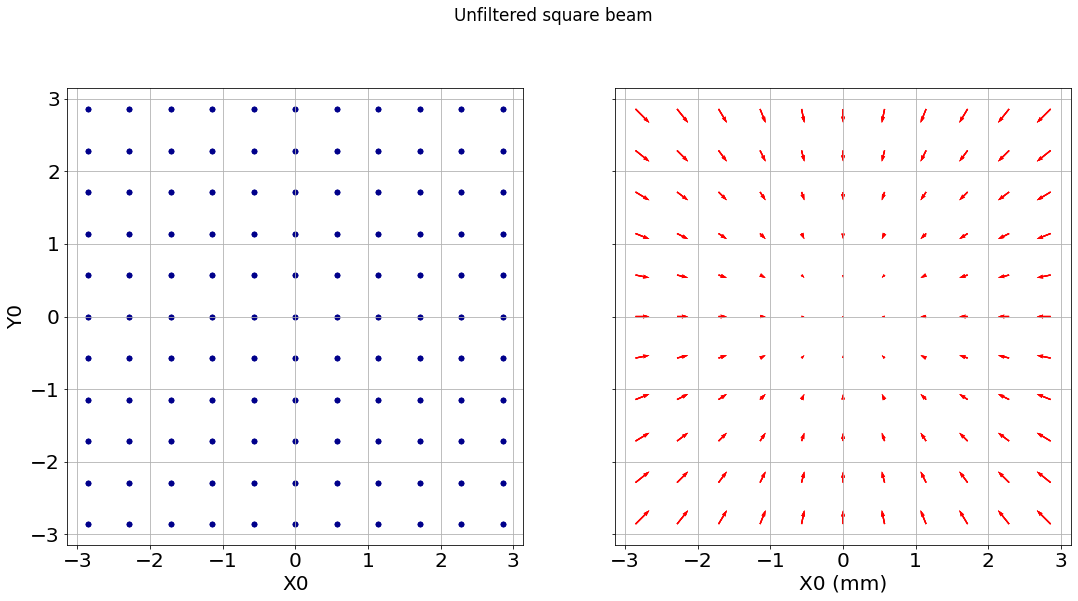

In [140]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
df.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
ax1.set_aspect("equal")
ax1.grid()

q = ax2.quiver(df["X0"], df["Y0"], df["U0"], df["V0"],color="red")
ax2.set_aspect("equal")
ax2.set_xlabel("X0 (mm)")
ax2.grid()

plt.suptitle("Unfiltered square beam")

In [141]:
df_filter=df.copy()

In [142]:
#df_filter["sel_flag"]= df_filter.apply(Select_Beam, axis=1)

In [143]:
#df_filter

In [144]:
# Do the filtering of the selected rays
df_filter=df_filter.loc[df_filter.apply(Select_Beam, axis=1)]

Text(0.5, 0.98, 'Filtered circular beam')

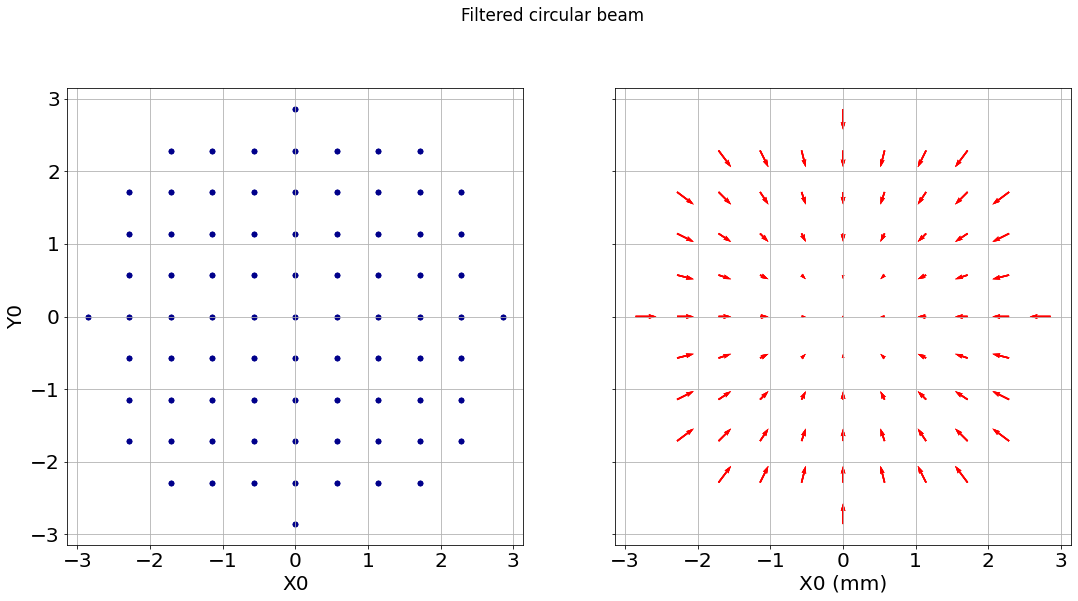

In [145]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9),sharex=True,sharey=True)
df_filter.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker="o",ax=ax1)
ax1.set_aspect("equal")
ax1.grid()

q = ax2.quiver(df_filter["X0"], df_filter["Y0"], df_filter["U0"], df_filter["V0"],color="red")
ax2.set_aspect("equal")
ax2.set_xlabel("X0 (mm)")
ax2.grid()

plt.suptitle("Filtered circular beam")

## reafect df_filter to df

In [146]:
df_filter=df_filter.reset_index()   # reset index
df=df_filter.copy()

In [147]:
#df.reindex()

In [148]:
NBEAMS=len(df)

## Where the beam rays are going

In [149]:
WL_IR=0.001

In [150]:
df_IR=df.loc[df.wave==WL_IR]

In [151]:
NBEAMS=len(df_IR)

In [152]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBEAMS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBEAMS), alpha=1)

<ipython-input-153-4610b223806c>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle("wavelength = 1 $\mu$ m",Y=1.1,fontsize=25)


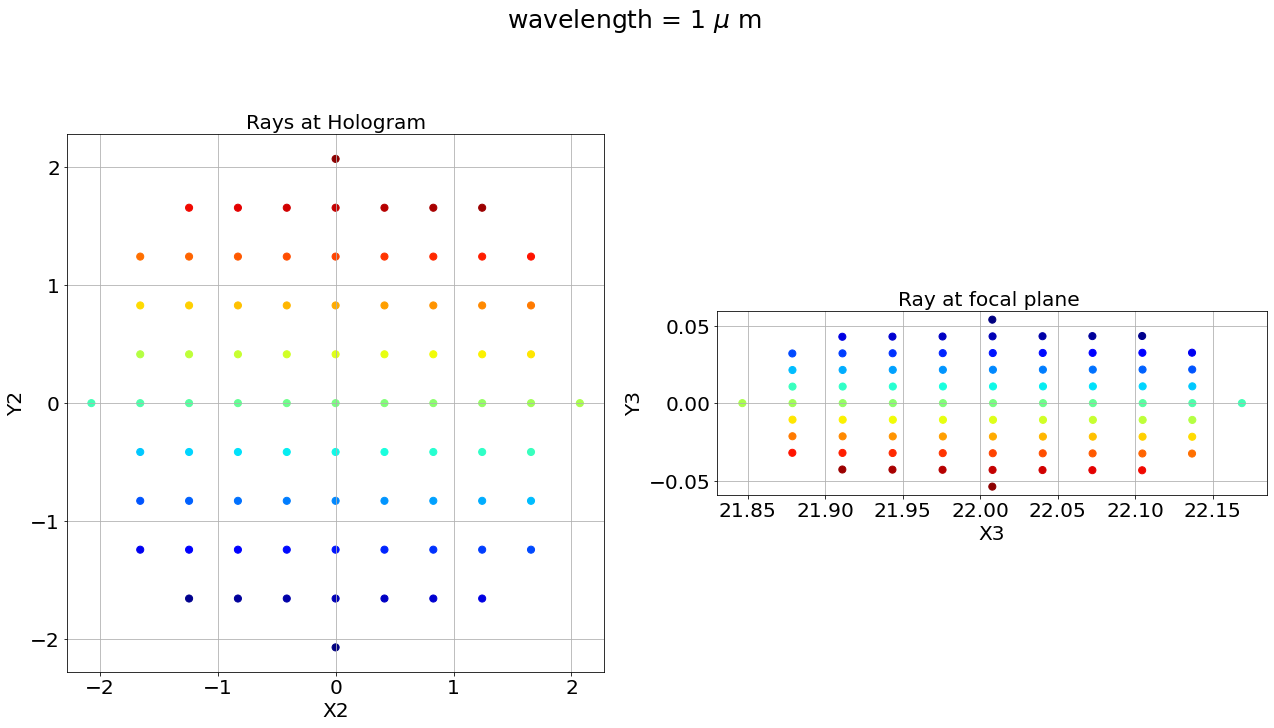

In [153]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,9))
df_IR.plot.scatter(x="X2", y="Y2",c=all_colors,marker="o",ax=ax1,s=50)
ax1.set_aspect("equal")
ax1.grid()
ax1.set_title("Rays at Hologram")


df_IR.plot.scatter(x="X3", y="Y3",c=all_colors,marker="o",ax=ax2,s=50)
ax2.set_aspect("equal")
ax2.grid()
ax2.set_title("Ray at focal plane ")

plt.suptitle("wavelength = 1 $\mu$ m",Y=1.1,fontsize=25)
plt.tight_layout()

## PSF

Text(0.5, 0, 'Y (mm)')

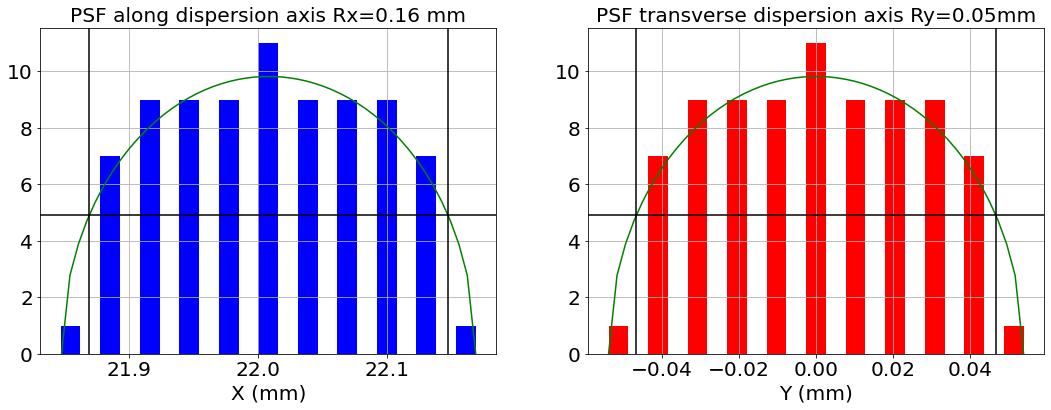

In [154]:
f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,6))
Xpos=df_IR["X3"].values
Ypos=df_IR["Y3"].values
NBINS=21
RX=Xpos.max()-Xpos.mean()
RY=Ypos.max()-Ypos.mean()
h1=np.histogram(Xpos,bins=NBINS)
h2=np.histogram(Ypos,bins=NBINS)

counts1, bins1 = h1
counts2, bins2 = h2

NPOINTS=50
all_x=np.linspace(-RX,RX,NPOINTS)
all_y=np.linspace(-RY,RY,NPOINTS)
DX=4/NBINS*NBEAMS*(2*RX)
DY=4/NBINS*NBEAMS*(2*RY)

Yx=1/np.pi/RX*DX*np.sqrt(1-all_x**2/RX**2)
Yy=1/np.pi/RY*DY*np.sqrt(1-all_y**2/RY**2)
YxMax=1/np.pi/RX*DX
YyMax=1/np.pi/RY*DY

#ax1.hist(Xpos,bins=NBINS,facecolor="blue",density=True)
ax1.hist(bins1[:-1], bins1, weights=counts1,facecolor="blue",density=False)
ax1.plot(all_x+Xpos.mean(),Yx,color='green')
ax1.grid()
ax1.set_title("PSF along dispersion axis Rx={:2.2f} mm".format(RX))
ax1.axhline(y=YxMax/2,color="k")
ax1.axvline(x=-np.sqrt(3)*RX/2.+Xpos.mean(),color="k")
ax1.axvline(x=np.sqrt(3)*RX/2.+Xpos.mean(),color="k")
ax1.set_xlabel("X (mm)")

#ax2.hist(Ypos,bins=NBINS,facecolor="red",density=True)
ax2.hist(bins2[:-1], bins2, weights=counts2,facecolor="red",density=False)
ax2.plot(all_y+Ypos.mean(),Yy,color="green")
ax2.axhline(y=YyMax/2.,color="k")
ax2.axvline(x=-np.sqrt(3)*RY/2.+Ypos.mean(),color="k")
ax2.axvline(x=np.sqrt(3)*RY/2.+Ypos.mean(),color="k")
ax2.grid()
ax2.set_title("PSF transverse dispersion axis Ry={:2.2f}mm".format(RY))
ax2.set_xlabel("Y (mm)")

## Fit transverse dispersion

In [155]:
@custom_model
def exponential(x, a=10., b=1., c=0.):
    '''
    f(x)=a*exp(b*x + c)
    '''
    return a*np.exp(-np.abs(b*(x-c)))

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude               mean              stddev     
    ------------------ --------------------- ----------------
    3.8571431956664317 4.093841223317621e-14 80.5839138758898
Model: Lorentz1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude               x_0                   fwhm       
    ----------------- ----------------------- -------------------
    5.420805276413652 -1.5496611293371717e-18 0.08324398547879391
Model: Trapezoid1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude     x_0 width slope
    ----------------- --- ----- -----
    3.857142857142833 0.0   1.0   1.0
Model: exponential
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            a                 b                   c          
    ----------------- ----------------- ---------------------
    5.651681401829826 14.86717834943751 -0.006787079537395227

Text(0.5, 1.0, 'Fit PSF in Y axis')

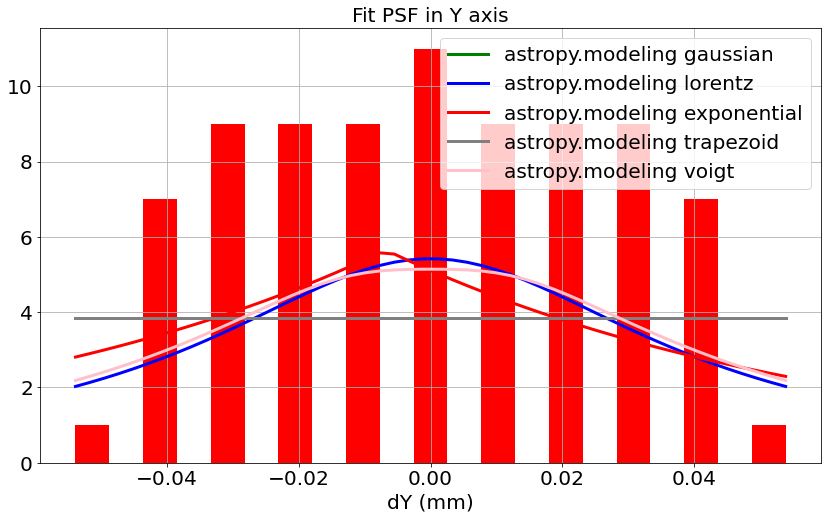

In [156]:
f, ax = plt.subplots(figsize=(14,8))
Xpos=df_IR["X3"].values
Ypos=df_IR["Y3"].values
NBINS=21
RX=Xpos.max()-Xpos.mean()
RY=Ypos.max()-Ypos.mean()
# compute the histogram
h1=np.histogram(Xpos,bins=NBINS)
h2=np.histogram(Ypos,bins=NBINS)
counts1, bins1 = h1
counts2, bins2 = h2

# compute bin width
binwidths2=(np.roll(bins2,-1)-bins2)[:-1]
binwidth2=np.mean(binwidths2)

# What to fit
theX=(bins2+binwidth2/2)[:-1]
theY=counts2

# fitter 
#fitter = fitting.LinearLSQFitter()
fitter = fitting.LevMarLSQFitter() 

# gaussian fit
model_gauss = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_gauss = fitter_gauss(model_gauss, theX,theY,weights=1)
print(best_fit_gauss)

# models in astropy
model_lorentz = models.Lorentz1D(amplitude=10., x_0=0.)
model_trapezoid = models.Trapezoid1D(amplitude=100., x_0=0.)
#model_exponential = models.Exponential1D(amplitude=10.,fwhm=0.05)
model_exponential = exponential(a=10., b=1., c=0.)
model_voigt = models.Voigt1D()

best_fit_lorentz=fitter(model_lorentz, theX,theY,weights=1)
best_fit_trapezoid=fitter(model_trapezoid, theX,theY,weights=1)
best_fit_exponential=fitter(model_exponential, theX,theY,weights=1)
best_fit_voigt=fitter(model_voigt, theX,theY,weights=1)

# do the fit
#best_fit = fitter(model, log_period, k_mag, weights=1.0/k_mag_err**2)
print(best_fit_lorentz)
print(best_fit_trapezoid)
print(best_fit_exponential)
print(best_fit_voigt)

ax.hist(bins2[:-1], bins2, weights=counts2,facecolor="red",density=False)

Xfit=np.linspace(-RY,RY,50)
plt.plot(Xfit, best_fit_gauss(Xfit), 'g-', linewidth=3, label='astropy.modeling gaussian')
plt.plot(Xfit, best_fit_lorentz(Xfit), 'b-', linewidth=3, label='astropy.modeling lorentz')
plt.plot(Xfit, best_fit_exponential(Xfit), 'r-', linewidth=3, label='astropy.modeling exponential')
plt.plot(Xfit, best_fit_trapezoid(Xfit), '-', color="grey",linewidth=3, label='astropy.modeling trapezoid')
plt.plot(Xfit, best_fit_voigt(Xfit), '-', color="pink",linewidth=3, label='astropy.modeling voigt')

ax.grid()
ax.legend()
ax.set_xlabel("dY (mm)")
ax.set_title("Fit PSF in Y axis")

# decoding by wavelength

In [157]:
wave=df["wave"]

In [158]:
Xfinal=df["Xfinal"]
Yfinal=df["Yfinal"]

In [159]:
selected_indexes1=np.where(wave==0.0004)
selected_indexes2=np.where(wave==0.0006)
selected_indexes3=np.where(wave==0.0008)
selected_indexes4=np.where(wave==0.0010)

In [160]:
def GetInfo(a):
    a_av=np.mean(a)   # mean
    a_rms=np.std(a)   # RMS
    a_min=np.min(a)   # Min
    a_max=np.max(a)   # Max 
    a_width=a_max-a_min   # Width
    return a_av,a_rms,a_min,a_max,a_width

In [161]:
def ComputeFWHM(values,nbins,thetitle="fwhm",flagplot=False):
    """
    ComputeFWHM(values,nbins,flagplot)
    
    input arg :
       values : list of values
       nbins. : number of bins in the histogram
       flagplot : flag to plot the distribution
    """
    
    counts, bins =np.histogram(values,bins=nbins)
    
    # compute bin width
    binwidths=(np.roll(bins,-1)-bins)[:-1]
    binwidth=np.mean(binwidths)
    
    # find max
    idx_max=np.where(counts==counts.max())[0][0]
    count_max=counts[idx_max]
    counts_halfmax=count_max/2.
    
    # bins above half max
    topmost=np.where(counts>=counts_halfmax)[0]
    idx_min_fwhm=topmost[0]
    idx_max_fwhm=topmost[-1]
    
    # lower upper part
    min_fwhm=bins[idx_min_fwhm]+binwidth/2.
    max_fwhm=bins[idx_max_fwhm]+binwidth/2.
    
    #fwhm
    fwhm=max_fwhm-min_fwhm
    
    
    if flagplot:
        f, ax = plt.subplots(figsize=(10,5))
        
        ax.hist(bins[:-1]+binwidth/2., bins+binwidth/2., weights=counts,facecolor="red",density=False)
        ax.axhline(y=counts_halfmax)
        ax.axvline(x=min_fwhm,color="k")
        ax.axvline(x=max_fwhm,color="k")
        
        ax.grid()
        ax.set_title(thetitle)
        
    return fwhm
            

In [162]:
# 400 nm
x1=Xfinal[selected_indexes1[0]]
y1=Yfinal[selected_indexes1[0]]
x1av,x1std,x1min,x1max,x1wdt=GetInfo(x1)
y1av,y1std,y1min,y1max,y1wdt=GetInfo(y1)

In [163]:
fwhmx1=ComputeFWHM(x1-x1av,nbins=11,thetitle="FWHM x1",flagplot=False)
fwhmy1=ComputeFWHM(y1-y1av,nbins=11,thetitle="FWHM y1",flagplot=False)
print("fwhm_x1= = {:2.2f}, fwhm_y1={:2.4f}".format(fwhmx1,fwhmy1))

fwhm_x1= = 0.05, fwhm_y1=0.0188


In [164]:
rxmax1=np.max([x1.max()-x1av,x1av-x1.min()])
rymax1=np.max([y1.max()-y1av,y1av-y1.min()])
print("rmax_x1= = {:2.2f}, rmax_y1={:2.4f}".format(rxmax1,rymax1))

rmax_x1= = 0.04, rmax_y1=0.0129


In [165]:
# 600 nm
x2=Xfinal[selected_indexes2[0]]
y2=Yfinal[selected_indexes2[0]]
x2av,x2std,x2min,x2max,x2wdt=GetInfo(x2)
y2av,y2std,y2min,y2max,y2wdt=GetInfo(y2)

In [166]:
fwhmx2=ComputeFWHM(x2-x2av,nbins=11,thetitle="FWHM x2",flagplot=False)
fwhmy2=ComputeFWHM(y2-y2av,nbins=11,thetitle="FWHM y2",flagplot=False)
print("fwhm_x2= = {:2.2f}, fwhm_y2={:2.4f}".format(fwhmx2,fwhmy2))

fwhm_x2= = 0.01, fwhm_y2=0.0047


In [167]:
rxmax2=np.max([x2.max()-x2av,x2av-x2.min()])
rymax2=np.max([y2.max()-y2av,y2av-y2.min()])
print("rmax_x2= = {:2.2f}, rmax_y2={:2.4f}".format(rxmax2,rymax2))

rmax_x2= = 0.01, rmax_y2=0.0032


In [168]:
# 800 nm
x3=Xfinal[selected_indexes3[0]]
y3=Yfinal[selected_indexes3[0]]
x3av,x3std,x3min,x3max,x3wdt=GetInfo(x3)
y3av,y3std,y3min,y3max,y3wdt=GetInfo(y3)

In [169]:
fwhmx3=ComputeFWHM(x3-x3av,nbins=11,thetitle="FWHM x3",flagplot=False)
fwhmy3=ComputeFWHM(y3-y3av,nbins=11,thetitle="FWHM y3",flagplot=False)
print("fwhm_x3= = {:2.2f}, fwhm_y3={:2.4f}".format(fwhmx3,fwhmy3))

fwhm_x3= = 0.08, fwhm_y3=0.0268


In [170]:
rxmax3=np.max([x3.max()-x3av,x3av-x3.min()])
rymax3=np.max([y3.max()-y3av,y3av-y3.min()])
print("rmax_x3= = {:2.2f}, rmax_y3={:2.4f}".format(rxmax3,rymax3))

rmax_x3= = 0.05, rmax_y3=0.0184


In [171]:
# 1000 nm
x4=Xfinal[selected_indexes4[0]]
y4=Yfinal[selected_indexes4[0]]
x4av,x4std,x4min,x4max,x4wdt=GetInfo(x4)
y4av,y4std,y4min,y4max,y4wdt=GetInfo(y4)

In [172]:
fwhmx4=ComputeFWHM(x4-x4av,nbins=11,thetitle="FWHM x4",flagplot=False)
fwhmy4=ComputeFWHM(y4-y4av,nbins=11,thetitle="FWHM y4",flagplot=False)
print("fwhm_x4= = {:2.2f}, fwhm_y4={:2.4f}".format(fwhmx4,fwhmy4))

fwhm_x4= = 0.23, fwhm_y4=0.0783


In [173]:
rxmax4=np.max([x4.max()-x4av,x4av-x4.min()])
rymax4=np.max([y4.max()-y4av,y4av-y4.min()])
print("rmax_x4= = {:2.2f}, rmax_y4={:2.4f}".format(rxmax4,rymax4))

rmax_x4= = 0.16, rmax_y4=0.0538


In [174]:
# Pack the four colors
xav=np.array([x1av,x2av,x3av,x4av])
xstd=np.array([x1std,x2std,x3std,x4std])
xmin=np.array([x1min,x2min,x3min,x4min])
xmax=np.array([x1max,x2max,x3max,x4max])
xwdt=np.array([x1wdt,x2wdt,x3wdt,x4wdt])
xfwhm=np.array([fwhmx1,fwhmx2,fwhmx3,fwhmx4])
xrmax=np.array([rxmax1,rxmax2,rxmax3,rxmax4])
yav=np.array([y1av,y2av,y3av,y4av])
ystd=np.array([y1std,y2std,y3std,y4std])
ymin=np.array([y1min,y2min,y3min,y4min])
ymax=np.array([y1max,y2max,y3max,y4max])
ywdt=np.array([y1wdt,y2wdt,y3wdt,y4wdt])
yfwhm=np.array([fwhmy1,fwhmy2,fwhmy3,fwhmy4])
yrmax=np.array([rymax1,rymax2,rymax3,rymax4])

In [175]:
dataout = {'xav': xav,'xstd' :xstd,'xmin' :xmin,'xmax' :xmax,'xwdt':xwdt,'xfwhm':xfwhm,'xrmax':xrmax,
           'yav': yav,'ystd' :ystd,'ymin' :ymin,'ymax' :ymax,'ywdt':ywdt,'yfwhm':yfwhm,'yrmax':yrmax}

In [176]:
df_out = pd.DataFrame(dataout, index = ['400nm', '600nm', '800nm', '1000nm'])

In [177]:
df_out.head()

,xav,xstd,xmin,xmax,xwdt,xfwhm,xrmax,yav,ystd,ymin,ymax,ywdt,yfwhm,yrmax
400nm,8.314969,0.019111,8.27777,8.35273,0.07496,0.054516,0.037761,-1.499144e-19,0.006584,-0.01292,0.01292,0.02584,0.018793,0.01292
600nm,12.635639,0.004811,12.62626,12.64513,0.01887,0.013724,0.009491,1.606225e-20,0.001650,-0.00324,0.00324,0.00648,0.004713,0.00324
800nm,17.167191,0.027634,17.11278,17.22117,0.10839,0.078829,0.054411,-8.566536e-19,0.009384,-0.01842,0.01842,0.03684,0.026793,0.01842
1000nm,22.008016,0.082128,21.84664,22.16877,0.32213,0.234276,0.161376,2.826957e-18,0.027429,-0.05383,0.05383,0.10766,0.078298,0.05383


In [178]:
df_out.to_excel(outputdata_excel)

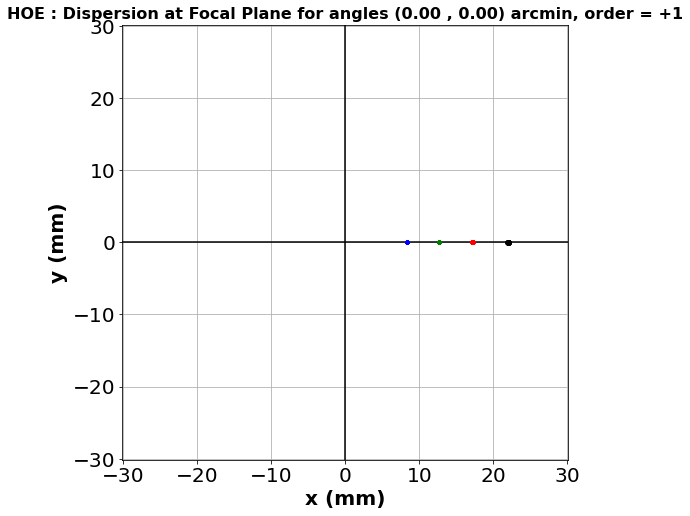

In [179]:
plt.figure(figsize=(8,8))
plt.axhline(y=0,color="k")
plt.axvline(x=0,color="k")
plt.plot(x1,y1,"b.")
plt.plot(x2,y2,"g.")
plt.plot(x3,y3,"r.")
plt.plot(x4,y4,"k.")

plt.xlim(-Det_size/2,Det_size/2.)
plt.ylim(-Det_size/2,Det_size/2)
plt.grid(True)
plt.xlabel("x (mm)",fontweight='bold')
plt.ylabel("y (mm)",fontweight='bold')

plt.title(fulltitle1,fontsize=16,fontweight='bold')
plt.savefig(figname1)

In [180]:
x1

0     8.31494
1     8.29256
2     8.29997
3     8.30741
4     8.31490
       ...   
76    8.31490
77    8.32242
78    8.32997
79    8.33754
80    8.31494
Name: Xfinal, Length: 81, dtype: float64

In [181]:
Dispersion(400*1e-6,aeff,Filt_D*m_to_mm)

8.200765206954785

In [182]:
x2

81     12.63564
82     12.63000
83     12.63186
84     12.63374
85     12.63563
         ...   
157    12.63563
158    12.63752
159    12.63942
160    12.64132
161    12.63564
Name: Xfinal, Length: 81, dtype: float64

In [183]:
x3

162    17.16717
163    17.19963
164    17.18886
165    17.17805
166    17.16722
         ...   
238    17.16722
239    17.15637
240    17.14548
241    17.13457
242    17.16717
Name: Xfinal, Length: 81, dtype: float64

In [184]:
x4

243    22.00783
244    22.10445
245    22.07236
246    22.04020
247    22.00799
         ...   
319    22.00799
320    21.97574
321    21.94344
322    21.91112
323    22.00783
Name: Xfinal, Length: 81, dtype: float64

In [185]:
Neff

350

In [186]:
def ShowCircle(x, y, radius):
    
    circle = Circle((x, y), radius, linewidth=1,edgecolor='grey', facecolor=(0, 0, 0, .0125))
    return circle

In [187]:
def Showscale(x,y,w,label,ax):
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    ax.axhline(y=y,color="k")
    ax.axvline(x=x,color="k")
    ax.plot([xmin+xscale*.1,xmin+xscale*.1+wdt/10.],[ymin+yscale*0.8,ymin+yscale*0.8],'k-',lw=2)
    ax.text(xmin+xscale*.1, ymin+yscale*0.85, label,fontsize=16, fontweight='bold')

In [188]:
def Showscale2(x,y,w,label,ax):
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    ax.axhline(y=y,color="k")
    ax.axvline(x=x,color="k")
    ax.plot([xmax-xscale*.3,xmax-xscale*.3+wdt/10.],[ymin+yscale*0.1,ymin+yscale*0.1],'k-',lw=2)
    ax.text(xmax-xscale*.3, ymin+yscale*0.15, label,fontsize=20, fontweight='bold')

In [189]:
def Showscale3(x,y,w,wd,label,ax):
    """
        x,y,w : relative to the image
        wd : length of the label
    """
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    #ax.axhline(y=y,color="k")
    #ax.axvline(x=x,color="k")
    ax.plot([xmax-xscale*.3,xmax-xscale*.3+wd],[ymin+yscale*0.1,ymin+yscale*0.1],'k-',lw=2)
    ax.text(xmax-xscale*.3, ymin+yscale*0.15, label,fontsize=20, fontweight='bold')

In [190]:
def Showstat(x,y,w,xstd,ystd,ax):
    
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    stat_str_x="$\\sigma_x=${:2.2f} $\\mu$ m".format(xstd*1000)
    stat_str_y="$\\sigma_y=${:2.2f} $\\mu$ m".format(ystd*1000)
    print(stat_str_x)
    ax.text(xmax-xscale*.4, ymin+yscale*0.85, stat_str_x,fontsize=16, fontweight='bold')
    ax.text(xmax-xscale*.4, ymin+yscale*0.80, stat_str_y,fontsize=16, fontweight='bold')

In [191]:
def Showstat2(x,y,w,xstd,ystd,ax):
    
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    stat_str_x="$\\sigma_x=${:2.2f} $\\mu$ m".format(xstd*1000)
    stat_str_y="$\\sigma_y=${:2.2f} $\\mu$ m".format(ystd*1000)
    ax.text(xmin+xscale*.01, ymin+yscale*0.85, stat_str_x,fontsize=20, fontweight='bold')
    ax.text(xmin+xscale*.01, ymin+yscale*0.75, stat_str_y,fontsize=20, fontweight='bold')

In [192]:
def Showstat3(x,y,w,fwx,fwy,ax):
    
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    stat_str_x="fwhm$_x=${:2.0f} $\\mu m$".format(fwx*1000)
    stat_str_y="fwhm$_y=${:2.0f} $\\mu m$".format(fwy*1000)
    ax.text(xmin+xscale*.01, ymin+yscale*0.85, stat_str_x,fontsize=20, fontweight='bold')
    ax.text(xmin+xscale*.01, ymin+yscale*0.75, stat_str_y,fontsize=20, fontweight='bold')

In [193]:
def Showstat4(x,y,w,fwx,fwy,ax):
    
    xmin=x-w/2
    xmax=x+w/2
    ymin=y-w/2
    ymax=y+w/2
    xscale=xmax-xmin
    yscale=ymax-ymin
    stat_str_x="fwhm$_u=${:2.0f} $\\mu m$".format(fwx*1000)
    stat_str_y="fwhm$_v=${:2.0f} $\\mu m$".format(fwy*1000)
    ax.text(xmin+xscale*.01, ymin+yscale*0.85, stat_str_x,fontsize=20, fontweight='bold')
    ax.text(xmin+xscale*.01, ymin+yscale*0.75, stat_str_y,fontsize=20, fontweight='bold')

In [194]:
def GetStatStr(fwx,fwy):
    stat_str_x="fwhm$_x=${:2.0f} $\\mu m$".format(fwx*1000)
    stat_str_y="fwhm$_y=${:2.0f} $\\mu m$".format(fwy*1000)
    fwhm_str="fwhm$_x=${:2.0f} $\\mu m$   \\  fwhm$_y=${:2.0f} $\\mu m$ ".format(fwx*1000,fwy*1000)
    
    textstr = '\n'.join((
    r'$fwhm_x=%.0f~\mu m$' % (fwx*1000, ),
    r'$fwhm_y=%.0f~\mu m$' % (fwy*1000, )))
    return textstr

In [195]:
def GetStatStr2(fwx,fwy):
    stat_str_x="fwhm$_u=${:2.0f} $\\mu m$".format(fwx*1000)
    stat_str_y="fwhm$_v=${:2.0f} $\\mu m$".format(fwy*1000)
    fwhm_str="fwhm$_u=${:2.0f} $\\mu m$   \\  fwhm$_v=${:2.0f} $\\mu m$ ".format(fwx*1000,fwy*1000)
    
    textstr = '\n'.join((
    r'$fwhm_u=%.0f~\mu m$' % (fwx*1000, ),
    r'$fwhm_v=%.0f~\mu m$' % (fwy*1000, )))
    return textstr

In [196]:
wdt=1.40  # width 1.4 mm to cope with total width for Ronchi  400 of 1.4 mm
scalelabel="140 $\mu$m"
xmin=x1av-wdt
xmax=x1av+wdt
ymin=y1av-wdt
ymax=y1av+wdt
xscale=xmax-xmin
yscale=ymax-ymin

In [197]:
seeing_radius=1./pltscale/2. # in mm
seeing_str="seeing 1\" fwhm ({:2.0f}  $\mu m$) ".format(seeing_radius*2000)
seeing_str1="seeing 1\" "
seeing_str2="fwhm = {:2.0f} $\mu m$".format(seeing_radius*2000)

In [198]:
seeing_str

'seeing 1" fwhm (61  $\\mu m$) '

In [199]:
seeing_radius

0.03054323321940223

$\sigma_x=$19.11 $\mu$ m
$\sigma_x=$4.81 $\mu$ m
$\sigma_x=$27.63 $\mu$ m
$\sigma_x=$82.13 $\mu$ m


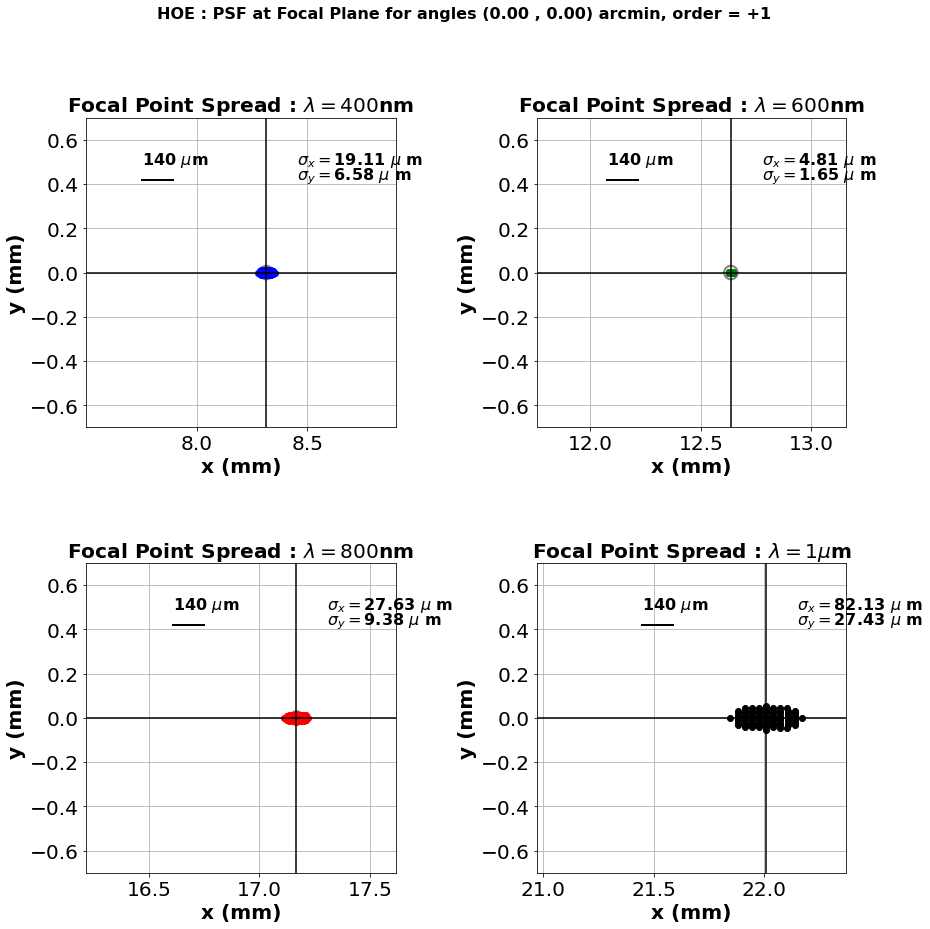

In [200]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(x1, y1,'bo')

Showscale(x1av,y1av,wdt,scalelabel,ax1)
Showstat(x1av,y1av,wdt,x1std,y1std,ax1)

x1calc=Dispersion(400*1e-6,aeff,Filt_D*m_to_mm)
y1calc=0


#ax1.set_xlim(x1av-wdt/2,x1av+wdt/2)
#ax1.set_ylim(y1av-wdt/2,y1av+wdt/2)

ax1.set_xlim(x1calc-wdt/2,x1calc+wdt/2)
ax1.set_ylim(y1calc-wdt/2,y1calc+wdt/2)

#circle1=ShowCircle(x1av, x1av, seeing_radius)
circle1 = Circle((x1av, y1av), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
ax1.add_artist(circle1)
#circle1 = Circle(x1av-wdt*(1./4.), y1av-wdt*(1./4.+1./8.), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
#ax1.add_artist(circle1)
#ax1.text(x1av-wdt*(1/2-1/10),y1av-wdt*(1/4-2/8),seeing_str,fontsize=16, fontweight='bold')


ax1.set_title('Focal Point Spread : $\lambda=400$nm',fontweight='bold')
ax1.set_xlabel('x (mm)',fontweight='bold')
ax1.set_ylabel('y (mm)',fontweight='bold')
ax1.set_aspect("equal")
ax1.grid()
#----
ax2.plot(x2, y2,'go')
Showscale(x2av,y2av,wdt,scalelabel,ax2)
Showstat(x2av,y2av,wdt,x2std,y2std,ax2)

x2calc=Dispersion(600*1e-6,aeff,Filt_D*m_to_mm)
y2calc=0


#ShowCircle(x2av, x2av, seeing_radius,ax2)
circle2 = Circle((x2av, y2av), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
ax2.add_artist(circle2)
#ax2.set_xlim(x2av-wdt/2,x2av+wdt/2)
#ax2.set_ylim(y2av-wdt/2,y2av+wdt/2)

ax2.set_xlim(x2calc-wdt/2,x2calc+wdt/2)
ax2.set_ylim(y2calc-wdt/2,y2calc+wdt/2)

ax2.set_xlabel('x (mm)',fontweight='bold')
ax2.set_ylabel('y (mm)',fontweight='bold')
ax2.grid()
ax2.set_aspect("equal")
ax2.set_title('Focal Point Spread : $\lambda=600$nm',fontweight='bold')
#--------

x3calc=Dispersion(800*1e-6,aeff,Filt_D*m_to_mm)
y3calc=0



ax3.plot(x3, y3,'ro')
Showscale(x3av,y3av,wdt,scalelabel,ax3)
Showstat(x3av,y3av,wdt,x3std,y3std,ax3)
circle3 = Circle((x3av, y3av), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
ax3.add_artist(circle3)
#ax3.set_xlim(x3av-wdt/2,x3av+wdt/2)
#ax3.set_ylim(y3av-wdt/2,y3av+wdt/2)

ax3.set_xlim(x3calc-wdt/2,x3calc+wdt/2)
ax3.set_ylim(y3calc-wdt/2,y3calc+wdt/2)

ax3.set_xlabel('x (mm)',fontweight='bold')
ax3.set_ylabel('y (mm)',fontweight='bold')
ax3.grid()
ax3.set_aspect("equal")
ax3.set_title('Focal Point Spread : $\lambda=800$nm',fontweight='bold')




#-----

x4calc=Dispersion(1000*1e-6,aeff,Filt_D*m_to_mm)
y4calc=0


ax4.plot(x4, y4,'ko')
Showscale(x4av,y4av,wdt,scalelabel,ax4)
Showstat(x4av,y4av,wdt,x4std,y4std,ax4)
circle4 = Circle((x4av, y4av), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
ax4.add_artist(circle4)
#ax4.set_xlim(x4av-wdt/2,x4av+wdt/2)
#ax4.set_ylim(y4av-wdt/2,y4av+wdt/2)

ax4.set_xlim(x4calc-wdt/2,x4calc+wdt/2)
ax4.set_ylim(y4calc-wdt/2,y4calc+wdt/2)

ax4.set_xlabel('x (mm)',fontweight='bold')
ax4.set_ylabel('y (mm)',fontweight='bold')
ax4.grid()
ax4.set_aspect("equal")
ax4.set_title('Focal Point Spread : $\lambda=1\mu$m',fontweight='bold')

plt.suptitle(fulltitle2,fontsize=16,fontweight='bold',y=1.02)
plt.tight_layout()
plt.savefig(figname2)

In [201]:
seeing_str

'seeing 1" fwhm (61  $\\mu m$) '

In [202]:
if  FLAG_R400:
 
    fwhmx1=FWHMX_R400_SIMBEAM[0] 
    fwhmy1=FWHMY_R400_SIMBEAM[0] 
    
    fwhmx2=FWHMX_R400_SIMBEAM[1] 
    fwhmy2=FWHMY_R400_SIMBEAM[1] 

    fwhmx3=FWHMX_R400_SIMBEAM[2] 
    fwhmy3=FWHMY_R400_SIMBEAM[2] 
    
    fwhmx4=FWHMX_R400_SIMBEAM[3] 
    fwhmy4=FWHMY_R400_SIMBEAM[3] 

elif  FLAG_R300:
    
    fwhmx1=FWHMX_R300_SIMBEAM[0] 
    fwhmy1=FWHMY_R300_SIMBEAM[0] 
    
    fwhmx2=FWHMX_R300_SIMBEAM[1] 
    fwhmy2=FWHMY_R300_SIMBEAM[1] 

    fwhmx3=FWHMX_R300_SIMBEAM[2] 
    fwhmy3=FWHMY_R300_SIMBEAM[2] 
    
    fwhmx4=FWHMX_R300_SIMBEAM[3] 
    fwhmy4=FWHMY_R300_SIMBEAM[3]
    
elif  FLAG_HOE:  
    
    fwhmx1=FWHMX_HOE_SIMBEAM[0] 
    fwhmy1=FWHMY_HOE_SIMBEAM[0] 
    
    fwhmx2=FWHMX_HOE_SIMBEAM[1] 
    fwhmy2=FWHMY_HOE_SIMBEAM[1] 

    fwhmx3=FWHMX_HOE_SIMBEAM[2] 
    fwhmy3=FWHMY_HOE_SIMBEAM[2] 
    
    fwhmx4=FWHMX_HOE_SIMBEAM[3] 
    fwhmy4=FWHMY_HOE_SIMBEAM[3]


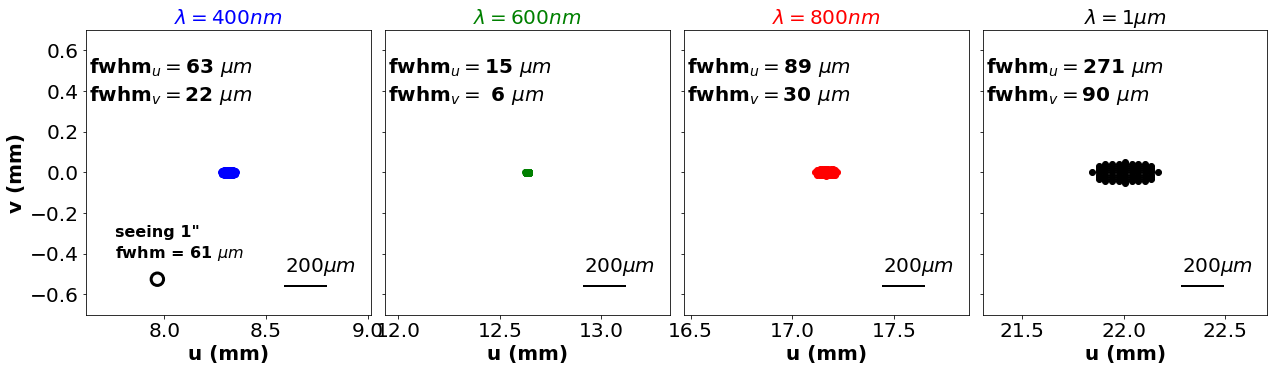

In [203]:
f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4,figsize=(18,6),sharey=True)
#-----
ax1.plot(x1, y1,'bo')
#Showscale2(x1av,y1av,wdt,scalelabel,ax1)
Showscale3(x1av,y1av,wdt,0.2,"$200 \mu m$",ax1)
#Showstat2(x1av,y1av,wdt,x1std,y1std,ax1)
Showstat4(x1av,y1av,wdt,fwhmx1,fwhmy1,ax1)
circle1 = Circle((x1av-wdt/4, y1av-wdt/2*3/4), seeing_radius, linewidth=3,edgecolor='black', facecolor=(0, 0, 0, .0125))
ax1.text(x1av-wdt/2*(1-1/5), y1av-wdt/2*3/4*(1-2/5),seeing_str1,fontsize=16, fontweight='bold')
ax1.text(x1av-wdt/2*(1-1/5), y1av-wdt/2*3/4*(1-1/5),seeing_str2,fontsize=16, fontweight='bold')
ax1.add_artist(circle1)
ax1.set_xlim(x1av-wdt/2,x1av+wdt/2)
ax1.set_ylim(y1av-wdt/2,y1av+wdt/2)
ax1.set_title('$\lambda=400 nm$',fontweight='bold',color="b",fontsize=20)
ax1.set_xlabel('u (mm)',fontweight='bold',fontsize=20)
ax1.set_ylabel('v (mm)',fontweight='bold',fontsize=20)
ax1.set_aspect('equal')
#ax1.grid()
#----
ax2.plot(x2, y2,'go')
#Showscale2(x2av,y2av,wdt,scalelabel,ax2)
Showscale3(x2av,y2av,wdt,0.2,"$200 \mu m$",ax2)
#Showstat2(x2av,y2av,wdt,x2std,y2std,ax2)  # plot std
Showstat4(x2av,y2av,wdt,fwhmx2,fwhmy2,ax2) # plot fwhm
#circle2 = Circle((x2av-wdt/4, y2av-wdt/2*3/4), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
#ax2.text(x2av-wdt/2*(1-1/5), y2av-wdt/2*3/4*(1-1/5),seeing_str,fontsize=16, fontweight='bold')
#ax2.add_artist(circle2)
ax2.set_xlim(x2av-wdt/2,x2av+wdt/2)
ax2.set_ylim(y2av-wdt/2,y2av+wdt/2)
ax2.set_xlabel('u (mm)',fontweight='bold',fontsize=20)
#ax2.set_ylabel('y (mm)',fontweight='bold')
#ax2.grid()
ax2.set_aspect('equal')
ax2.set_title('$\lambda=600 nm$',fontweight='bold',color="g",fontsize=20)
#--------
ax3.plot(x3, y3,'ro')
#Showscale2(x3av,y3av,wdt,scalelabel,ax3)
Showscale3(x3av,y3av,wdt,0.2,"$200 \mu m$",ax3)
#Showstat2(x3av,y3av,wdt,x3std,y3std,ax3) # plot sigma
Showstat4(x3av,y3av,wdt,fwhmx3,fwhmy3,ax3) # plot fwhm
#circle3 = Circle((x3av-wdt/4, y3av-wdt/2*3/4), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
#ax3.text(x3av-wdt/2*(1-1/5), y3av-wdt/2*3/4*(1-1/5),seeing_str,fontsize=16, fontweight='bold')
#ax3.add_artist(circle3)
ax3.set_xlim(x3av-wdt/2,x3av+wdt/2)
ax3.set_ylim(y3av-wdt/2,y3av+wdt/2)
ax3.set_xlabel('u (mm)',fontweight='bold',fontsize=20)
#ax3.set_ylabel('y (mm)',fontweight='bold')
#ax3.grid()
ax3.set_aspect('equal')
ax3.set_title('$\lambda=800 nm$',fontweight='bold',color="r",fontsize=20)
#-----
ax4.plot(x4, y4,'ko')
#Showscale2(x4av,y4av,wdt,scalelabel,ax4)
Showscale3(x4av,y4av,wdt,0.2,"$200 \mu m$",ax4)
#Showstat2(x4av,y4av,wdt,x4std,y4std,ax4) # plt sigma
Showstat4(x4av,y4av,wdt,fwhmx4,fwhmy4,ax4) # plot fwhm
#circle4 = Circle((x4av-wdt/4, y4av-wdt/2*3/4), seeing_radius, linewidth=2,edgecolor='grey', facecolor=(0, 0, 0, .0125))
#ax4.text(x4av-wdt/2*(1-1/5), y4av-wdt/2*3/4*(1-1/5),seeing_str,fontsize=16, fontweight='bold')
#ax4.add_artist(circle4)
ax4.set_xlim(x4av-wdt/2,x4av+wdt/2)
ax4.set_ylim(y4av-wdt/2,y4av+wdt/2)
ax4.set_xlabel('u (mm)',fontweight='bold',fontsize=20)
ax4.set_aspect('equal')
#ax4.set_ylabel('y (mm)',fontweight='bold')
#ax4.grid()
ax4.set_title('$\lambda=1\mu m$',fontweight='bold',color="k",fontsize=20)
#plt.suptitle(fulltitle2,fontsize=16,fontweight='bold',y=1.02)


plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig(figname3)

In [204]:
seeing_str='\n'.join((
    r'{}'.format(seeing_str1),
    r'{}'.format(seeing_str2)))

x1av-x1calc= 0.11420392884768482
x2av-x2calc= 0.17784789791698685
x3av-x3calc= 0.2505244444444443
x4av-x4calc= 0.33733886405721947


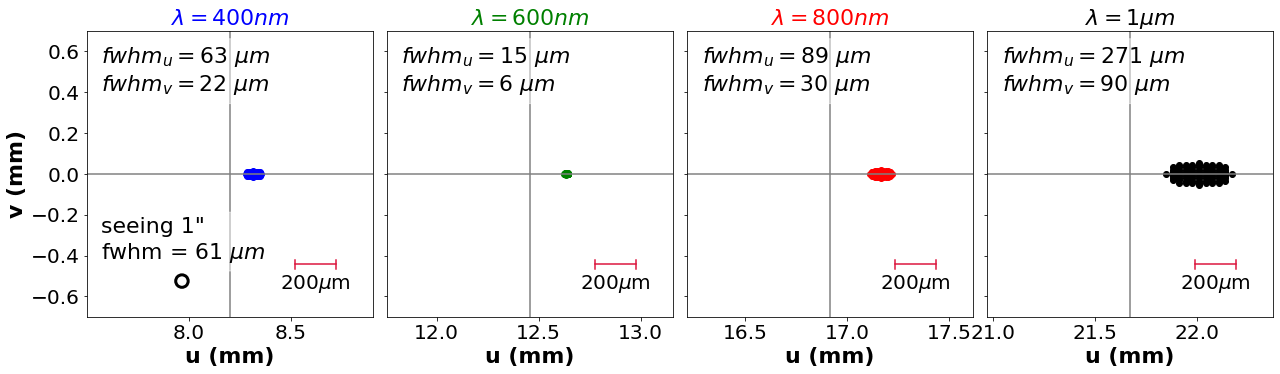

In [205]:
f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4,figsize=(18,6),sharey=True)
#-----
ax1.plot(x1, y1,'bo')

x1calc=Dispersion(400*1e-6,aeff,Filt_D*m_to_mm)
y1calc=0


ob = AnchoredHScaleBar(size=0.2, label="200$\mu$m", loc=4, frameon=False,pad=0.6,sep=4, linekw=dict(color="crimson"),textkw=dict(color="black",fontsize=20)) 
ax1.add_artist(ob) 
stat_str=GetStatStr2(fwhmx1,fwhmy1)
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.05, 0.95, stat_str, transform=ax1.transAxes, fontsize=22,fontweight='bold',verticalalignment='top', bbox=props)
ax1.text(0.05, 0.35, seeing_str, transform=ax1.transAxes, fontsize=22,verticalalignment='top', bbox=props)
circle1 = Circle((x1av-wdt/4, y1av-wdt/2*3/4), seeing_radius, linewidth=3,edgecolor='black', facecolor=(0, 0, 0, .0125))
ax1.add_artist(circle1)

#ax1.set_xlim(x1av-wdt/2,x1av+wdt/2)
#ax1.set_ylim(y1av-wdt/2,y1av+wdt/2)

ax1.set_xlim(x1calc-wdt/2,x1calc+wdt/2)
ax1.set_ylim(y1calc-wdt/2,y1calc+wdt/2)
ax1.scatter(x1av,y1av,marker="+",s=50,color="grey")
ax1.axvline(x=x1calc,color="grey")
ax1.axhline(y=y1calc,color="grey")

print("x1av-x1calc=",x1av-x1calc)


ax1.set_title('$\lambda=400 nm$',fontweight='bold',color="b",fontsize=22)
ax1.set_xlabel('u (mm)',fontweight='bold',fontsize=22)
ax1.set_ylabel('v (mm)',fontweight='bold',fontsize=22)
ax1.set_aspect('equal')
#ax1.grid()
#----
ax2.plot(x2, y2,'go')

x2calc=Dispersion(600*1e-6,aeff,Filt_D*m_to_mm)
y2calc=0

ob = AnchoredHScaleBar(size=0.2, label="200$\mu$m", loc=4, frameon=False,pad=0.6,sep=4, linekw=dict(color="crimson"),textkw=dict(color="black",fontsize=20)) 
ax2.add_artist(ob) 
stat_str=GetStatStr2(fwhmx2,fwhmy2)
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.05, 0.95, stat_str, transform=ax2.transAxes, fontsize=22,fontweight='bold',verticalalignment='top', bbox=props)

#ax2.set_xlim(x2av-wdt/2,x2av+wdt/2)
#ax2.set_ylim(y2av-wdt/2,y2av+wdt/2)

ax2.set_xlim(x2calc-wdt/2,x2calc+wdt/2)
ax2.set_ylim(y2calc-wdt/2,y2calc+wdt/2)
ax2.axvline(x=x2calc,color="grey")
ax2.axhline(y=y2calc,color="grey")
print("x2av-x2calc=",x2av-x2calc)

ax2.set_xlabel('u (mm)',fontweight='bold',fontsize=22)
ax2.set_aspect('equal')
ax2.set_title('$\lambda=600 nm$',fontweight='bold',color="g",fontsize=22)
#--------
ax3.plot(x3, y3,'ro')

x3calc=Dispersion(800*1e-6,aeff,Filt_D*m_to_mm)
y3calc=0

ob = AnchoredHScaleBar(size=0.2, label="200$\mu$m", loc=4, frameon=False,pad=0.6,sep=4, linekw=dict(color="crimson"),textkw=dict(color="black",fontsize=20)) 
ax3.add_artist(ob) 
stat_str=GetStatStr2(fwhmx3,fwhmy3)
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)
# place a text box in upper left in axes coords
ax3.text(0.05, 0.95, stat_str, transform=ax3.transAxes, fontsize=22,fontweight='bold',verticalalignment='top', bbox=props)

#ax3.set_xlim(x3av-wdt/2,x3av+wdt/2)
#ax3.set_ylim(y3av-wdt/2,y3av+wdt/2)
ax3.set_xlim(x3calc-wdt/2,x3calc+wdt/2)
ax3.set_ylim(y3calc-wdt/2,y3calc+wdt/2)
ax3.axvline(x=x3calc,color="grey")
ax3.axhline(y=y3calc,color="grey")
print("x3av-x3calc=",x3av-x3calc)


ax3.set_xlabel('u (mm)',fontweight='bold',fontsize=22)
#ax3.set_ylabel('y (mm)',fontweight='bold')
#ax3.grid()
ax3.set_aspect('equal')
ax3.set_title('$\lambda=800 nm$',fontweight='bold',color="r",fontsize=22)
#-----

ax4.plot(x4, y4,'ko')

x4calc=Dispersion(1000*1e-6,aeff,Filt_D*m_to_mm)
y4calc=0


ob = AnchoredHScaleBar(size=0.2, label="200$\mu$m", loc=4, frameon=False,pad=0.6,sep=4, linekw=dict(color="crimson"),textkw=dict(color="black",fontsize=20)) 
ax4.add_artist(ob) 
stat_str=GetStatStr2(fwhmx4,fwhmy4)
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)
# place a text box in upper left in axes coords
ax4.text(0.05, 0.95, stat_str, transform=ax4.transAxes, fontsize=22,fontweight='bold',verticalalignment='top', bbox=props)

#ax4.set_xlim(x4av-wdt/2,x4av+wdt/2)
#ax4.set_ylim(y4av-wdt/2,y4av+wdt/2)
ax4.set_xlim(x4calc-wdt/2,x4calc+wdt/2)
ax4.set_ylim(y4calc-wdt/2,y4calc+wdt/2)
ax4.axvline(x=x4calc,color="grey")
ax4.axhline(y=y4calc,color="grey")
print("x4av-x4calc=",x4av-x4calc)

ax4.set_xlabel('u (mm)',fontweight='bold',fontsize=22)
ax4.set_aspect('equal')
#ax4.set_ylabel('y (mm)',fontweight='bold')
#ax4.grid()
ax4.set_title('$\lambda=1\mu m$',fontweight='bold',color="k",fontsize=22)
#plt.suptitle(fulltitle2,fontsize=16,fontweight='bold',y=1.02)


plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig(figname3)

In [206]:
figname3

'HOE_PSF_Beam4_Rayfile_484_allwl_m00_m00_v2.pdf'

In [207]:
df_out.index.values

array(['400nm', '600nm', '800nm', '1000nm'], dtype=object)

# Interpolate

In [208]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [209]:
from scipy.interpolate import interp1d

In [210]:
X=df_out.index.values
Y=df_out['xstd'].values*1000 # in microns units

In [211]:
X=np.array([400.,600.,800.,1000.])

In [212]:
f = interp1d(X, Y, kind='cubic')

In [213]:
Xint=np.linspace(X[0],X[-1],100)
Yint=f(Xint)

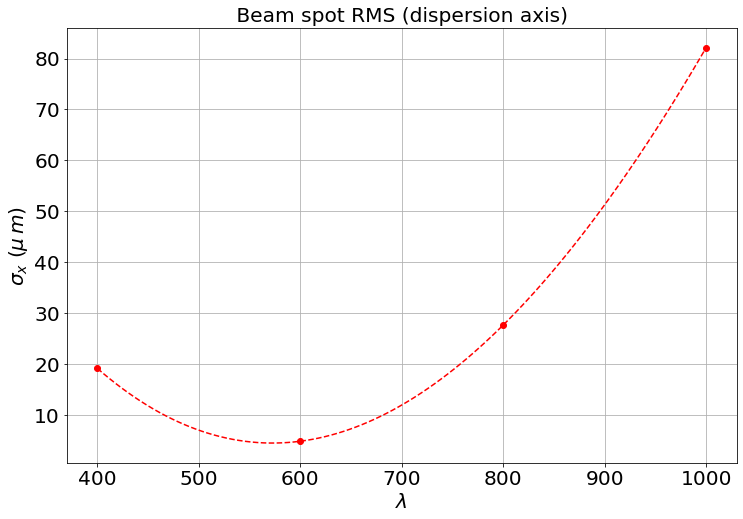

In [214]:
plt.figure(figsize=(12,8))
plt.plot(X,Y,'ro')
plt.plot(Xint,Yint,"r--")
plt.title(" Beam spot RMS (dispersion axis) ")
plt.xlabel("$\lambda$")
plt.ylabel("$\sigma_x$ ($\mu \, m$)")
plt.grid()

In [215]:
idx=find_nearest_idx(Xint,750)

In [216]:
Yint[idx]

18.98559348912802

In [217]:
Yint[idx]*16.4/1000

0.3113637332216995

In [218]:
idx=find_nearest_idx(Xint,1000)

In [219]:
Yint[idx]

82.12771532521147

In [220]:
Yint[idx]*16.4/1000

1.346894531333468